#### Imports

In [25]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

#### Data preparation

    1. Load data

In [26]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [27]:
train.sample()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
6792,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
Y_train = train['label']
X_train = train.drop(columns=['label'])

    2. Check for null and missing values

Check for images with missing values.

In [29]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [30]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

There are no missing values in the train and test dataset so we can go ahead.

    3. Normalization

In [31]:
X_train = X_train / 255
test = test / 255

    4. Reshape

Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)

In [32]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

Train and test images (28px x 28px) have been stock into pandas dataframe as 1D vector of 784 values. We need to reshape the data to 28 x 28 x 1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so they use only one channel. For RGB images, there are 3 channels so we would have reshaped 784px to 28 x 28 x 3 3D matrices.

    5. Label encoding

Encode labels to one hot vectors (ex: 2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [33]:
Y_train.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [34]:
from keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes=10)

    6. Split training and validation set

In [35]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

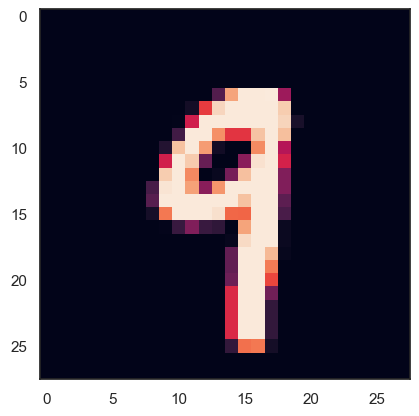

In [36]:
plt.imshow(X_train[2][:,:,0])

#### CNN Model

    1. Define the model

**model.add(Conv2D(...))** adds a convolutional layer to the model. Convolution is a fundamental operation in image processing that extracts local features.

- **filters=32** indicates the layer will have 32 filters (also known as kernels). Each filter learns to detect different patterns in the input.

- **kernel_size=(5,5)** specifies the size of the convolutional kernel or filter. In this case, the kernel is a 5x5 matrix that slides over the input to perform convolution.

- **padding='Same'** controls how to handle the image border. 'Same' means the border is padded with zeros to maintain the input size after convolution.

- **activation='relu'** indicates the Rectified Linear Unit (ReLU) activation function will be applied after convolution. ReLU is commonly used to introduce non-linearities in the network.

- **input_shape=(28,28,1)** specifies the input shape to the layer. In this case, it expects a 28x28-pixel image with a single color channel (grayscale). The '1' in the last dimension denotes a single channel.

**model.add(MaxPool2D(pool_size=(2,2)))**

- **MaxPool2D** es una capa de reducción de muestreo o pooling en una red neuronal convolucional.

- **pool_size=(2,2)** specifies the window size for performing max pooling. In this case, it's a 2x2-pixel window. The purpose of this layer is to reduce the spatial size of the representation, thereby reducing the number of parameters and computations in the network while preserving important features learned by the convolutional layers. Max pooling takes the maximum value from each window of the image and retains it, discarding the rest.

**model.add(Dropout(0.25))**

- **Dropout** is a regularization technique used to reduce overfitting in neural network models.

- **0.25** indicates the fraction of units in the network that will be randomly deactivated during training. During training, Dropout randomly deactivates a fraction of the neurons from the preceding layer, forcing the network to learn features in a more robust manner, preventing it from becoming too specialized in certain features of the training data. This helps improve the model's generalization to new data and reduces the risk of overfitting.

#### **Lines of code typically found towards the end of a Convolutional Neural Network (CNN) architecture**

**model.add(Flatten()):** The Flatten layer is used to convert the 2D feature maps obtained from the convolutional layers into a 1D vector. This is necessary because the subsequent layers (Dense layers) expect a one-dimensional input.

**model.add(Dense(256, activation = "relu")):** The Dense layer with 256 units (neurons) and ReLU activation takes the flattened 1D vector and applies a linear operation to produce a set of outputs. The ReLU activation introduces non-linearity to the network.

**model.add(Dropout(0.5)):** Used after the Dense layer to regularize the network  by randomly dropping out a fraction (here, 50%) of the units/neurons during training, which helps prevent overfitting.

**model.add(Dense(10, activation = "softmax")):** This last Dense layer has 10 units, corresponding to the number of classes in the classification task. The softmax activation function is used here, which normalizes the outputs for each class into probability-like values, allowing the model to predict the probability that an input belongs to each class. The class with the highest probability is chosen as the final prediciton.

This architecture's purpose is to transition from the feature extraction done by the convolutional layers to a format suitable for classification. The Dense layers act as a classifier, taking the learned features and making predicitons. The final Softmax layer provides probabilities for each class, enabling the model to make predicitons about the input data's class membership probabilities.

In [37]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

    2. Set optimizer and annealer

Setting the optimizer and using  an annealing technique are common practices in training neural networks, especially in deep learning models.

**Optimizer:** Responsible for updating the weights of the neural network during training in order to minimize the loss function. It implements optimization algorithms such as Stochastic Gradient Descent (SGD), Adam, RMSprop, etc. Each optimizer has its own characteristics and update rules.

**Learning Rate Annealing:** Annealing refers to the process of gradually reducing the learning rate during training. It can help the optimization processby allowing the model to converge faster and potentially reach a better optimum. Learning rate annealing is used to prevent the model from overshooting the minimum and to refine the learning process by decreasing the learning rate over time.

Combining an optimizer with a learning rate annealing strategy allows for more efficient training by optimizing the model's convergence and allowing it to reach a better solution.

In [38]:
from tensorflow.keras.optimizers import RMSprop

# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)

# Compile the model
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

In [39]:
# Set a learning rate annealer
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [40]:
epochs = 16
batch_size = 86

    3. Data augmentation

**ImageDataGenerator** is a powerful tool in Keras used for real-time data augmentation during model training, primarily with image data. It allows you to generate bacthes of augmented data in real-time, on-the-fly, as the model is being trained.

Some key functionalities:
- **Data Augmentation:** It performs real-time data augmentation on images by applying various tranformations like rotations, shifts, flips, zooms, shear, and more. Data augmentation helps increase the diversity of the training dataset by creating modified versions of the images. This aids improving the model's ability to generalize and reduces overfitting.
- **Batch Processing:** It generated batches of augmented data. These batches can be directly fed into the model for training using the **`flow_from directory`** or **`flow`** methods.
- **Normalization and Preprocessing:** **`ImageDataGenrator`** can perform data preprocessing and normalization on the fly. For instance, it can rescale pixel values to a certain range (0 to 1) or substract the mean and divide by the standard deviation.
- **Usage with Model Training:** It integrates seamlessly with the **`fit_generator`** method in Keras, allowing you to use augmented data directly within the model training loop.

In [41]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    zoom_range=0.1,
    height_shift_range=0.1,
    width_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

datagen.fit(X_train)

In [42]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                              epochs=epochs, validation_data=(X_val, Y_val),
                              verbose=1, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[early_stop, learning_rate_reduction])

Epoch 1/16


C:\Users\noemi\AppData\Local\Temp\ipykernel_17304\1028432422.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),


439/439 [==============================] - 15s 33ms/step - loss: 0.4281 - accuracy: 0.8616 - val_loss: 0.0797 - val_accuracy: 0.9738 - lr: 0.0010
Epoch 2/16
439/439 [==============================] - 15s 33ms/step - loss: 0.1388 - accuracy: 0.9576 - val_loss: 0.0527 - val_accuracy: 0.9855 - lr: 0.0010
Epoch 3/16
439/439 [==============================] - 15s 33ms/step - loss: 0.1053 - accuracy: 0.9684 - val_loss: 0.0375 - val_accuracy: 0.9886 - lr: 0.0010
Epoch 4/16
439/439 [==============================] - 15s 34ms/step - loss: 0.0893 - accuracy: 0.9736 - val_loss: 0.0265 - val_accuracy: 0.9912 - lr: 0.0010
Epoch 5/16
439/439 [==============================] - 15s 34ms/step - loss: 0.0774 - accuracy: 0.9774 - val_loss: 0.0283 - val_accuracy: 0.9905 - lr: 0.0010
Epoch 6/16
439/439 [==============================] - 15s 34ms/step - loss: 0.0656 - accuracy: 0.9804 - val_loss: 0.0414 - val_accuracy: 0.9893 - lr: 0.0010
Epoch 7/16
439/439 [==============================] - 16s 37ms/step -

    Save trained model weights

In [ ]:
model.save_weights('../weights/my_model_weights.h5')

    Load trained model weights

In [ ]:
model.load_weights('../weights/my_model_weights.h5')

In [ ]:
results = model.predict(test)

875/875 [==============================] - 5s 6ms/step


In [ ]:
# select the index with the maximum probability
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("../submission/cnn_mnist_datagen.csv", index=False)